# View Landsat 8 Imagery with PQ mask
Apply the PQ mask to the data to hide areas covered by cloud or other factors.

Get landsat 8 images for a given time period and lat/long extents, choose a image and plot a false color composite. 


| Author(s):  |  Bex Dunn, Mike Barnes, Claire Krause, Damien Ayers, Arapaut Sivaprasad|
|----------|----------------|
| Created (adapted): | May 08, 2018 |
| Last edited: | May 10, 2018 |


## Step-by-step instructions
Let us go through the process step by step.

### 1. Import modules and libraries
All the modules and libraries below are standard ones available to all users. 

In [710]:
%pylab notebook

import datacube
from datacube.storage import masking
from datacube.storage.storage import write_dataset_to_netcdf

import xarray as xr
import numpy as np
import os
import rasterio
dc = datacube.Datacube(app='dc-plot landsat  FalseColour')

Populating the interactive namespace from numpy and matplotlib


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product', 'time', 'figsize', 'title']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### 2. The datacube query

**Edit the start and end dates and spatial bounds here if you wish**

The date range determines the number of scenes to be retrieved. About 16 days form one scene.

In [711]:
#Temporal range is defined
start_of_epoch = '2015-09-01'
end_of_epoch =  '2015-09-15'

#Wavelengths/bands of interest are defined
bands_of_interest = ['nir', 'swir1', 'swir2']
#bands_of_interest = ['pixelquality']

#Sensors of interest are defined
sensors = ['ls8']
product = 'nbar'

#Create bounding box
lat_max = -35.25
lat_min = -35.35
lon_max = 149.17
lon_min = 149.05

#Create query
query = {'time': (start_of_epoch, end_of_epoch)}
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)

### 3. Run the datacube extraction
**This may take some time. Be patient!**

The next two blocks of code are to extract the data.

**Firstly, we define the product and sensor (satellite)**

In [712]:
sensor = sensors[0]
filter_pq=True
product_name = '{}_{}_albers'.format(sensor, product)
mask_product = '{}_{}_albers'.format(sensor, 'pq')

**Secondly, we get the data (in the variable, ds) which will be used by the plotting functions later. **

In [713]:
ds = dc.load(product=product_name, group_by='solar_day', **query)
ds.attrs['affine'] = ds.affine
ds

<xarray.Dataset>
Dimensions:          (time: 1, x: 492, y: 500)
Coordinates:
  * time             (time) datetime64[ns] 2015-09-06T23:56:19.500000
  * y                (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
  * x                (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...
Data variables:
    coastal_aerosol  (time, y, x) int16 1964 1809 3075 3487 4269 4679 5040 ...
    blue             (time, y, x) int16 1861 1602 2859 3208 3925 4474 4908 ...
    green            (time, y, x) int16 1794 1740 3353 3709 4506 4936 5371 ...
    red              (time, y, x) int16 1840 1721 3264 3613 4570 5129 5660 ...
    nir              (time, y, x) int16 2685 2572 3861 4274 5160 5695 6149 ...
    swir1            (time, y, x) int16 2068 2134 3486 3937 4730 5280 5828 ...
    swir2            (time, y, x) int16 1559 1568 2714 3162 3922 4478 5025 ...
Attributes:
    crs:      EPSG:3577
    affine:   | 25.00, 0.00, 1542325.00|\n| 0.00,-25.00,-3953075.00|\n| 0.00,...

### 4. Extract the PQ data to use as mask. 
If pixel quality filtering is enabled, extract the PQ data to use as mask. This is stored in exactly the same format as the main data, but will be used to mask selected pixels. 

A bit of explanation here might be useful.

If the cloud covered regions are masked, by setting 'no_cloud' to both cloud_acca and cloud_fmask, then values of those pixels will be set as 'NaN'. On the other hand, if you set 'cloud' you will see the clouds and nothing else.

In [714]:
if ds.variables:
    # If pixel quality filtering is enabled, extract PQ data to use as mask
    if filter_pq:
        sensor_pq = dc.load(product=mask_product, group_by='solar_day', **query)
        # If PQ call returns data, use to mask input data
        if sensor_pq.variables:
            good_quality = masking.make_mask(sensor_pq.pixelquality,
                                             cloud_acca='no_cloud',
                                             cloud_shadow_acca='no_cloud_shadow',
                                             cloud_shadow_fmask='no_cloud_shadow',
                                             cloud_fmask='no_cloud',
                                             blue_saturated=False,
                                             green_saturated=False,
                                             red_saturated=False,
                                             nir_saturated=False,
                                             swir1_saturated=False,
                                             swir2_saturated=False,
                                             contiguous=True)
            # Apply mask to preserve only good data
            ds = ds.where(good_quality)

#### Masking flags explained [[1](https://data.gov.au/dataset/pixel-quality-pq25/resource/7ed90984-e53c-42dc-baa0-557e8cc0659a)]
Given below are the different flags that we can mask/unmask. 
- Saturated: means this band has exceeded the dynamic range of the sensor. 
- Established algorithms that detect clouds:
    - ACCA: Automated Cloud Cover Assessment
    - Fmask: Function of mask
        - ACCA is already widely used within the remote sensing community; it is fast and relatively accurate.  Fmask on the other hand is newer, but is rapidly becoming more established, and can provide a more accurate cloud mask than ACCA in certain cloud environments.


| Flag name          | Description                                      | Bit. No                                        | Value | Meaning        |
| -------------------|--------------------------------------------------|------------------------------------------------|-------|----------------|
| ga_good_pixel      | Best Quality Pixel                               | [13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0] | 16383 | True           |
| blue_saturated     | Blue band is saturated                           | 0                                              | 0     | True           |
|                    |                                                  | 0                                              | 1     | False          |
| green_saturated    | Green band is saturated                          | 1                                              | 0     | True           |
|                    |                                                  | 1                                              | 1     | False          |
| red_saturated      | Red band is saturated                            | 2                                              | 0     | True           |
|                    |                                                  | 2                                              | 1     | False          |
| nir_saturated      | NIR band is saturated                            | 3                                              | 0     | True           |
|                    |                                                  | 3                                              | 1     | False          |
| swir1_saturated    | SWIR1 band is saturated                          | 4                                              | 0     | True           |
|                    |                                                  | 4                                              | 1     | False          |
| tir1_saturated     | Thermal Infrared 1 band is saturated             | 5                                              | 0     | True           |
|                    |                                                  | 5                                              | 1     | False          |
| tir2_saturated     | Thermal Infrared 2 band is saturated             | 6                                              | 0     | True           |
|                    |                                                  | 6                                              | 1     | False          |
| swir2_saturated    | SWIR2 band is saturated                          | 7                                              | 0     | True           |
|                    |                                                  | 7                                              | 1     | False          |
| contiguous         | All bands for this pixel contain non-null values | 8                                              | 0     | False          |
|                    |                                                  | 8                                              | 1     | True           |
| land_sea           | Land or Sea                                      | 9                                              | 0     | sea            |
|                    |                                                  | 9                                              | 1     | land           |
| cloud_acca         | Cloud (ACCA)                                     | 10                                             | 0     | cloud          |
|                    |                                                  | 10                                             | 1     | no_cloud       |
| cloud_fmask        | Cloud (Fmask)                                    | 11                                             | 0     | cloud          |
|                    |                                                  | 11                                             | 1     | no_cloud       |
| cloud_shadow_acca  | Cloud Shadow (ACCA)                              | 12                                             | 0     | cloud_shadow   |
|                    |                                                  | 12                                             | 1     | no_cloud_shadow|
| cloud_shadow_fmask | Cloud Shadow (Fmask)                             | 13                                             | 0     | cloud_shadow   |
|                    |                                                  | 13                                             | 1     | no_cloud_shadow|


### 5. Create the image data to plot

In [715]:
time=0
bands = bands_of_interest
figsize=[7, 7]
title='My Plot'
t, y, x = ds[bands[0]].shape
rawimg = np.zeros((y, x, 3), dtype=np.float32)
for i, colour in enumerate(bands):
    rawimg[:, :, i] = ds[colour][time].values
img_toshow = rawimg / 5000

### 6. Plot the image

<IPython.core.display.Javascript object>


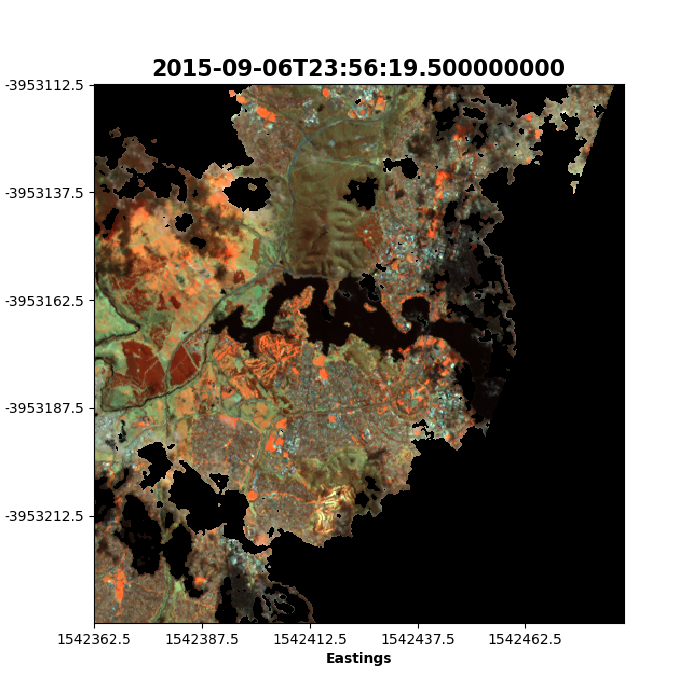

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0,0.5,'Northings')

In [716]:
fig = plt.figure(figsize=figsize)
plt.imshow(img_toshow)
ax = plt.gca()
ax.set_title(str(ds.time[time].values), fontweight='bold', fontsize=16)

ax.set_xticklabels(ds.x.values)
ax.set_yticklabels(ds.y.values)
ax.set_xlabel('Eastings', fontweight='bold')
ax.set_ylabel('Northings', fontweight='bold')
